# Introduction
In this notebook, we will  predict the sentiment of tweets  by using the text and basic classifers, and  try whether we can outperform these models with a **deep learning model**.


We download the data set from the Sentiment Labelled Sentences Data Set from the UCI Machine Learning Repository: "https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences".


# Importing packages 
To set-up of the project, let's first import some packages.

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
import nltk
#import nltk

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer


# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers


#nltk.download('stopwords')

Then we set some parameters that will be used throughout the notebook.

In [2]:
NB_WORDS = 5000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

We  download the data set from the Sentiment Labelled Sentences Data Set from the UCI Machine Learning Repository for this notebook.

We'll only keep the *sentence* column as input and the *label* column as the target. 

In [3]:
filepath_dict = {'yelp':   'data/yelp_labelled.txt',
                 'amazon': 'data/amazon_cells_labelled.txt',
                 'imdb':   'data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


# Data preparation

### Data cleaning
The first thing we'll do is removing stopwords which do not have any value for predicting the sentiment. As we want to build a model that can be used for other project as well, we remove the mentions.

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/abera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.sentence = df.sentence.apply(remove_stopwords).apply(remove_mentions)
df.head()

,sentence,label,source
0,Wow... Loved place.,1,yelp
1,Crust not good.,0,yelp
2,Not tasty texture nasty.,0,yelp
3,Stopped late May bank holiday Rick Steve recom...,1,yelp
4,The selection menu great prices.,1,yelp


### Train-Test split
 To determine how well the model generalizes, we will do first the *train_test_split* method of scikit-learn. We will evaluate  the model performance  on a separate test set.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.sentence, df.label, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 2473
# Test data samples: 275


### Converting words to numbers
To use the text as input for a model, we first need to convert the words into tokens, which simply means converting the words to integers that refer to an index in a dictionary. Here we will only keep the most frequent words in the train set.

We clean up the text by applying *filters* and putting the words to *lowercase*. Words are separated by spaces.

In [8]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 2473 documents
5000 words in dictionary
Top 5 most common words are: [('the', 443), ('not', 283), ('it', 249), ('good', 213), ('great', 191)]


After having created the dictionary we can convert the text to a list of integer indexes. This is done with the *text_to_sequences* method of the Tokenizer.

In [9]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

These integers should now be converted into a one-hot encoded features.

In [10]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[4, 15, 382, 968, 969]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 5.0 features with a value of 1.


### Converting the target classes to numbers
We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the *to_categorical* method in keras

In [11]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"0    0
0    0
0    1
Name: label, dtype: int64" is converted into 1
"1" is converted into [0. 1.]


### Splitting of a validation set
Now that our data is ready, we split of a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model. 

In [12]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (248, 5000)


# Deep learning

### Baseline model
We start with a model with 2 densely connected layers of 64 hidden elements. The *input_shape* for the first layer is equal to the number of words we allowed in the dictionary and for which we created one-hot-encoded features.

As we need to predict 2 different sentiment classes, the last layer has 2 hidden elements. The *softmax* activation function makes sure the two probabilities sum up to 1.

In the first layer we need to estimate 640064 weights. This is determined by (nb inputs * nb hidden elements) + nb bias terms, or (10000 x 64) + 64 = 640064<br>
In the last layer we estimate (64 x 2) + 2 = 130 weights<br>

In [13]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(2, activation='softmax'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320064    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 320,194
Trainable params: 320,194
Non-trainable params: 0
_________________________________________________________________


Because this project is a binary-class, single-label prediction, we use *binary_crossentropy* as the loss function and *softmax* as the final activation function. We fit the model on the remaining train data and validate on the validation set. We run for a predetermined number of epochs and will see when the model starts to overfit.

In [14]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='binary_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [15]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results
def test_model_train(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results_train = model.evaluate(X_train_oh, y_train_oh)
    
    return results_train

In [16]:
base_history=deep_model(base_model)

To evaluate the model performance, we will look at the training and validation loss and accuracy.

In [17]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, NB_START_EPOCHS + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

We can see here that both the validation loss and the training loss continue to lower. The training loss is lower than the validation loss after epoch 2. Thus, the training loss implies that it is normal as the model is trained to fit the train data as good as possible. Just as with the validation loss, the validation accuracy becomes lower at an early epoch 2. So to conclude, we can say that the model starts overfitting as from epoch 2.

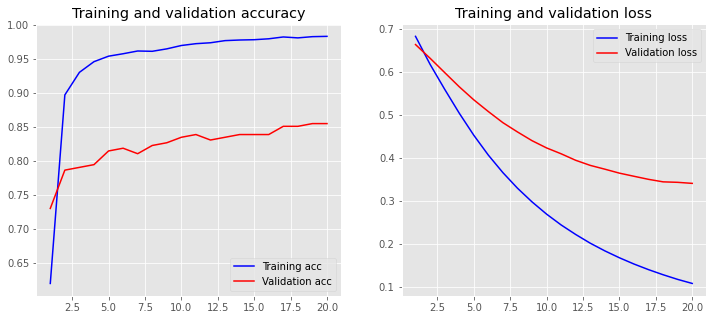

In [18]:
plot_history(base_history)

### Handling overfitting
Now, we can try to do something about the overfitting. 

#### Reducing the network's size
We reduce the network's size by removing one layer and lowering the number of hidden elements in the remaining layer to 32.

In [19]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(2, activation='softmax'))
reduced_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                160032    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 160,098
Trainable params: 160,098
Non-trainable params: 0
_________________________________________________________________


In [20]:
reduced_history = deep_model(reduced_model)

In [21]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'r', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

We can see that it takes about 3 epochs before the reduced model starts overfitting. Moreover, the loss increases much slower after that epoch compared to the baseline model.

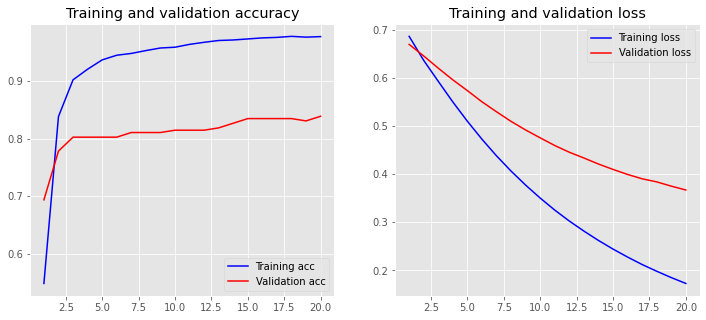

In [22]:
plot_history(reduced_history)

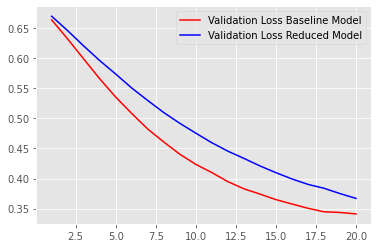

In [23]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

#### Adding regularization
To address overfitting, we can also add regularization to the model. Let's try with L2 regularization.

In [24]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
#reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(2, activation='softmax'))
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                320064    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 320,194
Trainable params: 320,194
Non-trainable params: 0
_________________________________________________________________


In [25]:
reg_history = deep_model(reg_model)

For the regularized model we notice that it starts decrease overfitting earlier than the baseline model. 

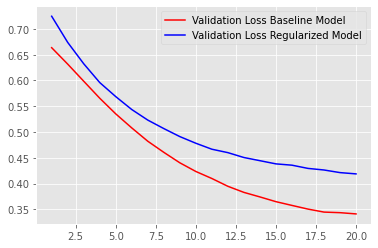

In [26]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

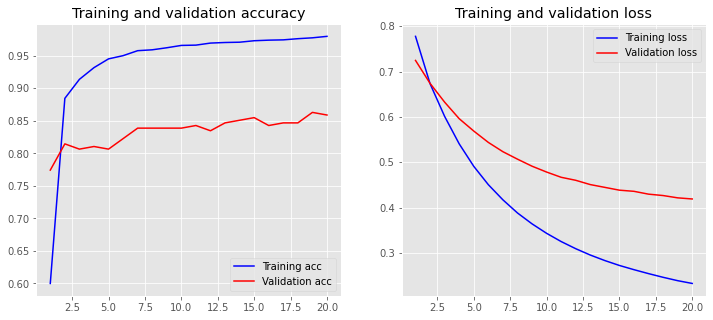

In [27]:
plot_history(reg_history)

#### Adding dropout layers
The last option we'll try is to add dropout layers.

In [28]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
#drop_model.add(layers.Dense(64, activation='relu'))
#drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(2, activation='softmax'))
drop_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                320064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 320,194
Trainable params: 320,194
Non-trainable params: 0
_________________________________________________________________


In [29]:
drop_history = deep_model(drop_model)

The model with dropout layers starts overfitting a bit later than the baseline model. The loss also increases slower than the baseline model.

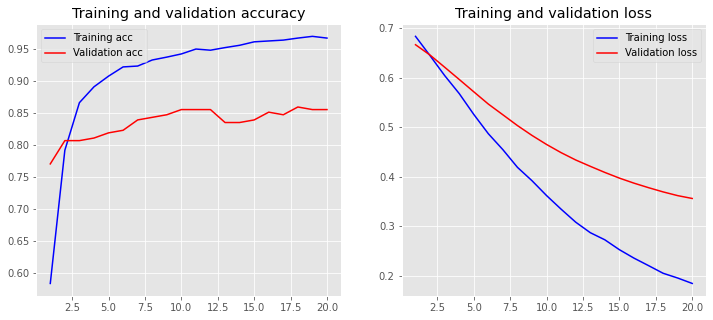

In [30]:
plot_history(drop_history)

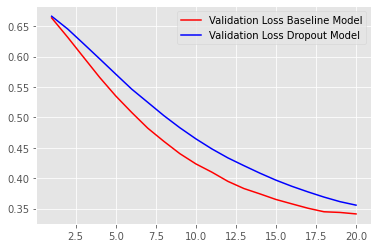

In [31]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

### Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [32]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [33]:
def test_model_train(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results_train = model.evaluate(X_train_oh, y_train_oh)
    
    return results_train

In [34]:
base_results = test_model(base_model, 4)
base_results_train = test_model_train(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))
print('Train accuracy of baseline model: {0:.2f}%'.format(base_results_train[1]*100))

78/78 [==============================] - 0s 2ms/step - loss: 0.0586 - accuracy: 0.9923
/n
Test accuracy of baseline model: 81.82%
Train accuracy of baseline model: 99.23%


In [35]:
reduced_results = test_model(reduced_model, 10)
reduced_results_train = test_model_train(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))
print('Train accuracy of reduced model: {0:.2f}%'.format(reduced_results_train[1]*100))

78/78 [==============================] - 0s 1ms/step - loss: 0.0490 - accuracy: 0.9927
/n
Test accuracy of reduced model: 80.73%
Train accuracy of reduced model: 99.27%


In [36]:
reg_results = test_model(reg_model, 5)
reg_results_train = test_model_train(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))
print('Train accuracy of regularized model: {0:.2f}%'.format(reg_results_train[1]*100))

78/78 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9858
/n
Test accuracy of regularized model: 80.73%
Train accuracy of regularized model: 98.58%


In [37]:
drop_results = test_model(drop_model, 6)
drop_results_train = test_model_train(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))
print('Train accuracy of dropout model: {0:.2f}%'.format(drop_results_train[1]*100))

78/78 [==============================] - 0s 2ms/step - loss: 0.0796 - accuracy: 0.9854
/n
Test accuracy of dropout model: 82.55%
Train accuracy of dropout model: 98.54%


As we can see above, the model with the reduced model performs the best on the test data. 


#### Word embeddings using a pretrained model and hyperparametric

In [38]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [39]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.sequence import pad_sequences

# Main settings
epochs = 10
embedding_dim = 50
maxlen = 100
output_file = 'data1/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished


finished amazon; write to file and proceed? [y/n]y
Running amazon data set
Best Accuracy : 0.8006
{'vocab_size': 4570, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8224


Running grid search for data set : imdb
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.4min finished


finished imdb; write to file and proceed? [y/n]y
Running imdb data set
Best Accuracy : 0.8064
{'vocab_size': 4570, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8195


Running grid search for data set : yelp
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.4min finished


finished yelp; write to file and proceed? [y/n]y
Running yelp data set
Best Accuracy : 0.8021
{'vocab_size': 4570, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8108




It is noted here that the pretrained models are slightly same as above models.

### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.1, random_state=37)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7600
Accuracy for amazon data: 0.8200
Accuracy for imdb data: 0.8000


This is slightly lower than what we achieved with the above models. 